In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def search_google_news(query, max_results=50):
    all_news_df = []

    total_results = 0
    visited_links = set()  # Set to store visited URLs

    # Encode special characters in the query
    encoded_query = encode_special_characters(query)
    
    # Base URL with placeholders for query and date parameters
    base_url = f"https://news.google.com/search?q={encoded_query}&hl=en-CA&gl=CA&ceid=CA%3Aen"

    while total_results < max_results:
        # Format the URL with query and date parameters
        url = base_url + f"&start={total_results}"
        
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        articles = soup.find_all('article')
        
        for article in articles:
            link = article.find('a')['href'].replace("./articles/", "https://news.google.com/articles/")
            if link in visited_links:
                continue  # Skip if link is already visited
            visited_links.add(link)

            news_text = article.get_text(separator='\n')
            news_text_split = news_text.split('\n')
            
            news_df = pd.DataFrame({  
                'Title': news_text_split[2],
                'Source': news_text_split[0],
                'Time': news_text_split[3],
                'Link': link,
                'Keywords': query  # Add a column for the keywords searched
            }, index=[0])
            
            all_news_df.append(news_df)

            total_results += 1

            if total_results >= max_results:
                break

    final_news_df = pd.concat(all_news_df, ignore_index=True)

    return final_news_df[:max_results]


def encode_special_characters(text):
    encoded_text = ''
    special_characters = {'&': '%26', '=': '%3D', '+': '%2B', ' ': '%20'}  
    for char in text.lower():
        encoded_text += special_characters.get(char, char)
    return encoded_text

query_list = ['Canada shelter rent', 'Canada shelter cost', 'Canada shelter price', 'Canada shelter rates', 'Canada shelter housing', 'Canada shelter homeowner',
              'Canada household operations cost', 'Canada household furnishings cost', 'Canada household equipment cost', 'Canada household utilities cost',
              'Canada public transportation cost', 'Canada private transportation cost', 'Canada transportation gasoline cost', 'Canada transportation mantainence repair cost',
              'Canada food stores cost', 'Canada food restaurants cost', 'Canada food meat cost', 'Canada food diary products cost', 'Canada food vegetables cost',
              'Canada clothing price cost', 'Canada health care price cost', 'Canada recreation price cost', 'Canada alcohol price cost' ]  # List of different search queries

all_news_dfs = []

for query in query_list:
    news_df = search_google_news(query, max_results=50)
    all_news_dfs.append(news_df)

final_news_df = pd.concat(all_news_dfs, ignore_index=True)

final_news_df.to_csv('news.csv', index=False)

final_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1150 non-null   object
 1   Source    1150 non-null   object
 2   Time      1150 non-null   object
 3   Link      1150 non-null   object
 4   Keywords  1150 non-null   object
dtypes: object(5)
memory usage: 45.1+ KB


In [20]:
final_news_df.head()

,Title,Source,Time,Link,Keywords
0,Feds to increase Canada Housing Benefit rent s...,Global News,Feb 6,https://news.google.com/articles/CBMifmh0dHBzO...,Canada shelter rent
1,Explore Canada's Rental Landscape in 2023,CMHC,Jan 31,https://news.google.com/articles/CBMidGh0dHBzO...,Canada shelter rent
2,Newcomers to Canada are more likely to be in u...,Canada Immigration News,Dec 30,https://news.google.com/articles/CBMieWh0dHBzO...,Canada shelter rent
3,Airbnb’s Devastating Effect on Canadian Housing,The Walrus,9 days ago,https://news.google.com/articles/CBMiLmh0dHBzO...,Canada shelter rent
4,Canadian housing inflation is sticking around ...,Financial Post,Feb 6,https://news.google.com/articles/CBMiQ2h0dHBzO...,Canada shelter rent


In [21]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# Import re module for regular expressions
import re

# Get the current date
current_date = pd.to_datetime('today')
current_month = current_date.month
current_year = current_date.year

# Iterate through each row in the DataFrame
for index, row in final_news_df.iterrows():
    date_str = row['Time']
    
    # Check if the date string is already in the format 'YYYY-MM-DD'
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        # If so, keep the value unchanged'
        #print ("if",date_str)
        continue
    
    # Check if the date string represents 'X days ago'
    elif re.match(r'^\d+ days ago$', date_str):
        #print ("if 1",date_str)
        days_ago = int(date_str.split()[0])
        date = current_date - pd.Timedelta(days=days_ago)
    
    # Check if the date string represents 'X hours ago'
    elif re.match(r'^\d+ hours ago$', date_str):
        #print ("if 2",date_str)
        hours_ago = int(date_str.split()[0])
        date = current_date - pd.Timedelta(hours=hours_ago)
    
    # Check if the date string represents 'X hour ago'
    elif re.match(r'^\d+ hour ago$', date_str):
        #print ("if 2",date_str)
        #hour_ago = int(date_str.split()[0])
        date = current_date 
    
    # Check if the date string represents 'X minutes ago'  
    elif re.match(r'^\d+ minutes ago$', date_str):
        #print ("if 2",date_str)
        minutes_ago = int(date_str.split()[0])
        date = current_date - pd.Timedelta(minutes=minutes_ago)

    elif re.match(r'^[A-Z][a-z]{2} \d{1,2}, \d{4}$', date_str):
        #print ("if 3",date_str)
        # Split the date string into month and day
        month_str, day_str, year_str = date_str.split()

        # Convert month abbreviation to month number
        month_dict = {
            'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
        }
        month = month_dict[month_str]

        # Convert day to integer
        day = int(day_str.strip(','))

        # Convert year to integer
        year = int(year_str)

        # Construct the date string
        date_str = f'{year}-{month:02d}-{day:02d}'

        # Convert the date string to a Timestamp object
        date = pd.to_datetime(date_str)

    # Check if the date string is "Yesterday"
    elif date_str == 'Yesterday':
        #print ("if 4",date_str)
        date = current_date - pd.Timedelta(days=1)

    # If the date string represents 'Month-Day'
    else:
        #print ("else",date_str)
        # Split the date string into month and day
        month_str, day_str = date_str.split(' ')

        # Convert month abbreviation to month number
        month_dict = {
            'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
        }
        month = month_dict[month_str]

        # Convert day to integer
        day = int(day_str)

        # Determine the year based on the current month
        year = current_year - 1 if month > current_month else current_year

        # Construct the date string
        date_str = f'{year}-{month:02d}-{day:02d}'

        # Convert the date string to a Timestamp object
        date = pd.to_datetime(date_str)

    # Update the "Time" column with the formatted date
    final_news_df.at[index, 'Time'] = date.strftime('%Y-%m-%d')

#print(news_df)


In [22]:
import pandas as pd
from datetime import datetime

final_news_df['Time'] = pd.to_datetime(final_news_df['Time'], format='%Y-%m-%d')

final_news_df = final_news_df.drop_duplicates(subset=['Title', 'Time'])
final_news_df = final_news_df[final_news_df['Time'] >= '2023-04-30']
final_news_df = final_news_df[final_news_df['Time'] <= '2024-02-29']
#final_news_df = final_news_df[final_news_df['Source'].str.contains('CBC.ca|CBC news')]


print(final_news_df.info())
final_news_df.to_csv('news2.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 0 to 1120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Title     535 non-null    object        
 1   Source    535 non-null    object        
 2   Time      535 non-null    datetime64[ns]
 3   Link      535 non-null    object        
 4   Keywords  535 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 25.1+ KB
None


In [23]:
from textblob import TextBlob
import pandas as pd

sentiment_results = []

for (month, keyword), group in final_news_df.groupby([pd.Grouper(freq='M', key='Time'), 'Keywords']):
    month_keyword_text = ' '.join(group['Title'])
    
    blob = TextBlob(month_keyword_text)
    average_sentiment = blob.sentiment.polarity
    
    sentiment_results.append({'Month': month.strftime('%Y-%m'), 'Keyword': keyword, 'Average Sentiment': average_sentiment})

sentiment_df = pd.DataFrame(sentiment_results)

print(sentiment_df)


       Month                                        Keyword  Average Sentiment
0    2023-05                     Canada clothing price cost           0.000000
1    2023-05                          Canada food meat cost           0.250000
2    2023-05                   Canada food restaurants cost           0.350000
3    2023-05                    Canada food vegetables cost           0.166667
4    2023-05                  Canada health care price cost           0.300000
..       ...                                            ...                ...
172  2024-02                         Canada shelter housing          -0.075000
173  2024-02                           Canada shelter price           0.179167
174  2024-02                           Canada shelter rates           0.104000
175  2024-02                            Canada shelter rent           0.048636
176  2024-02  Canada transportation mantainence repair cost           0.250000

[177 rows x 3 columns]


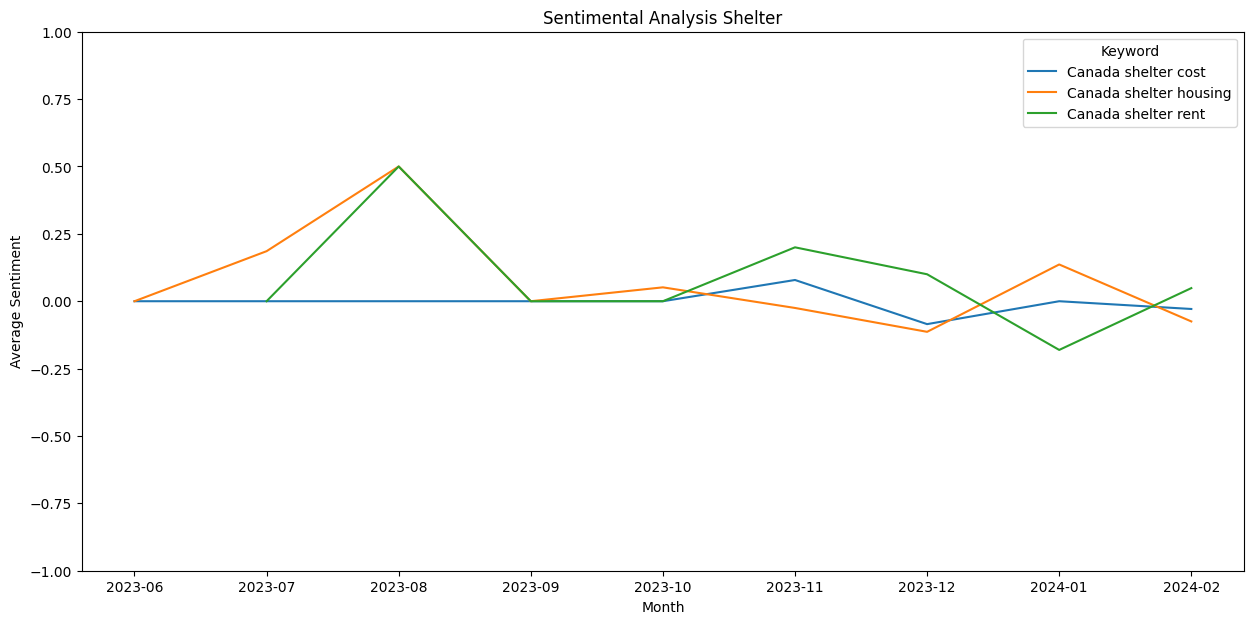

In [24]:
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords you want to consider
keywords_to_consider = ['Canada shelter rent', 'Canada shelter cost', 'Canada shelter housing']
# Filter sentiment_df to include only the rows where the 'Keyword' column is in keywords_to_consider
filtered_sentiment_df = sentiment_df[sentiment_df['Keyword'].isin(keywords_to_consider)]

# Plot the filtered data
#sns.lineplot(data=filtered_sentiment_df, x='Month', y='Average Sentiment', hue='Keyword', errorbar=('ci', False))



plt.figure(figsize=(15,7))
plt.title('Sentimental Analysis Shelter')
sns.lineplot(data=filtered_sentiment_df,x = 'Month' , y = 'Average Sentiment', errorbar=('ci', False) ,hue='Keyword')
#for index, row in sentiment_df.iterrows():
#     plt.annotate(f'{row["Average Sentiment"]:.2f}', (row['Month'], row['Average Sentiment']), fontsize=10 )
plt.ylim(-1, 1)
plt.legend(title='Keyword')


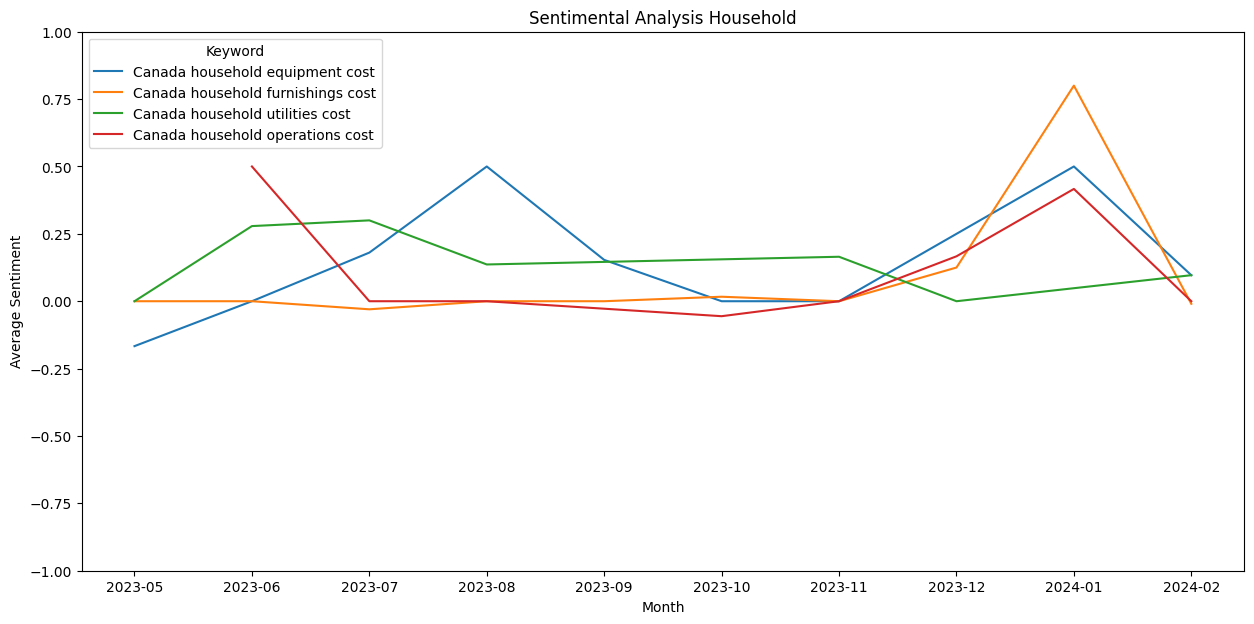

In [25]:
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords you want to consider
keywords_to_household = ['Canada household operations cost', 'Canada household furnishings cost', 'Canada household equipment cost', 'Canada household utilities cost']
# Filter sentiment_df to include only the rows where the 'Keyword' column is in keywords_to_consider
household_sentiment_df = sentiment_df[sentiment_df['Keyword'].isin(keywords_to_household)]

plt.figure(figsize=(15,7))
plt.title('Sentimental Analysis Household')
sns.lineplot(data=household_sentiment_df,x = 'Month' , y = 'Average Sentiment', errorbar=('ci', False) ,hue='Keyword')
#for index, row in sentiment_df.iterrows():
#     plt.annotate(f'{row["Average Sentiment"]:.2f}', (row['Month'], row['Average Sentiment']), fontsize=10 )
plt.ylim(-1, 1)
plt.legend(title='Keyword')

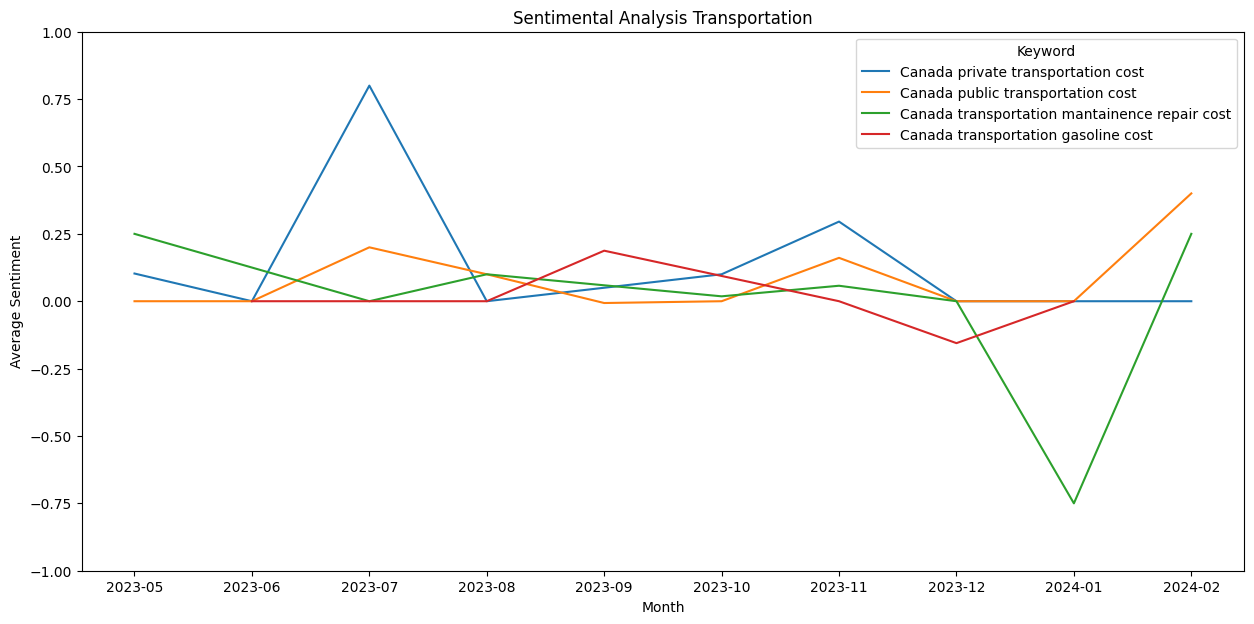

In [26]:
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords you want to consider
keywords_to_transportation = ['Canada public transportation cost', 'Canada private transportation cost', 'Canada transportation gasoline cost', 'Canada transportation mantainence repair cost']
# Filter sentiment_df to include only the rows where the 'Keyword' column is in keywords_to_consider
transportation_sentiment_df = sentiment_df[sentiment_df['Keyword'].isin(keywords_to_transportation)]

plt.figure(figsize=(15,7))
plt.title('Sentimental Analysis Transportation')
sns.lineplot(data=transportation_sentiment_df,x = 'Month' , y = 'Average Sentiment', errorbar=('ci', False) ,hue='Keyword')
#for index, row in sentiment_df.iterrows():
#     plt.annotate(f'{row["Average Sentiment"]:.2f}', (row['Month'], row['Average Sentiment']), fontsize=10 )
plt.ylim(-1, 1)
plt.legend(title='Keyword')

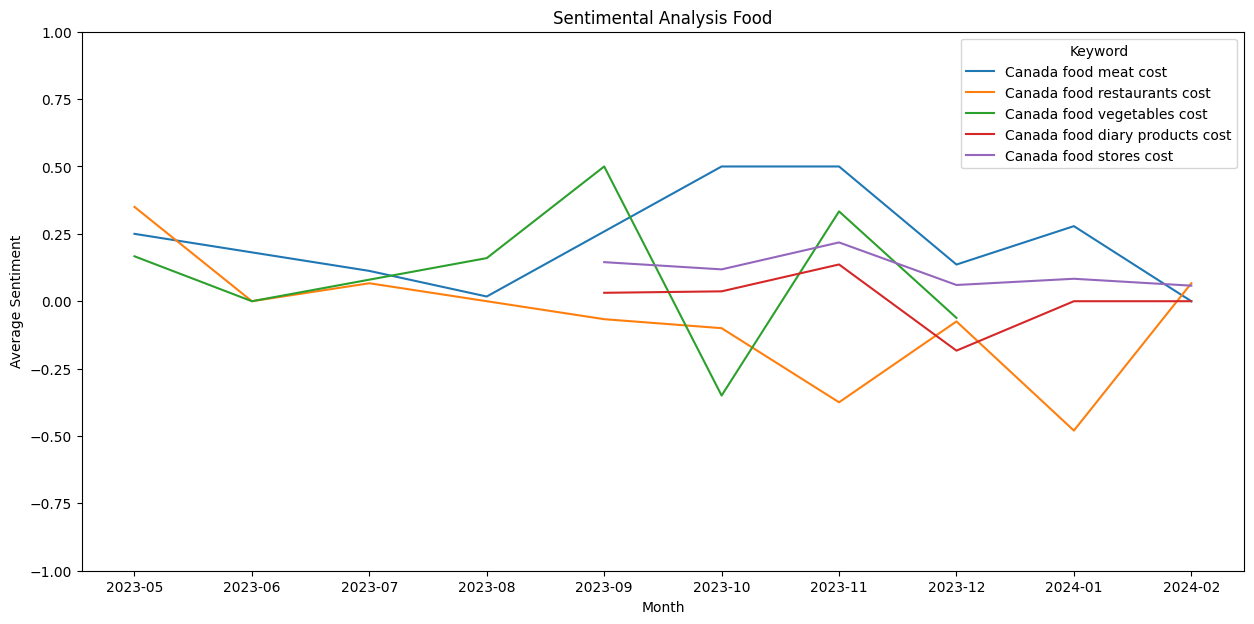

In [27]:
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords you want to consider
keywords_to_food = ['Canada food stores cost', 'Canada food restaurants cost', 'Canada food meat cost', 'Canada food diary products cost', 'Canada food vegetables cost']
# Filter sentiment_df to include only the rows where the 'Keyword' column is in keywords_to_consider
food_sentiment_df = sentiment_df[sentiment_df['Keyword'].isin(keywords_to_food)]


plt.figure(figsize=(15,7))
plt.title('Sentimental Analysis Food')
sns.lineplot(data=food_sentiment_df,x = 'Month' , y = 'Average Sentiment', errorbar=('ci', False) ,hue='Keyword')
#for index, row in sentiment_df.iterrows():
#     plt.annotate(f'{row["Average Sentiment"]:.2f}', (row['Month'], row['Average Sentiment']), fontsize=10 )
plt.ylim(-1, 1)
plt.legend(title='Keyword')

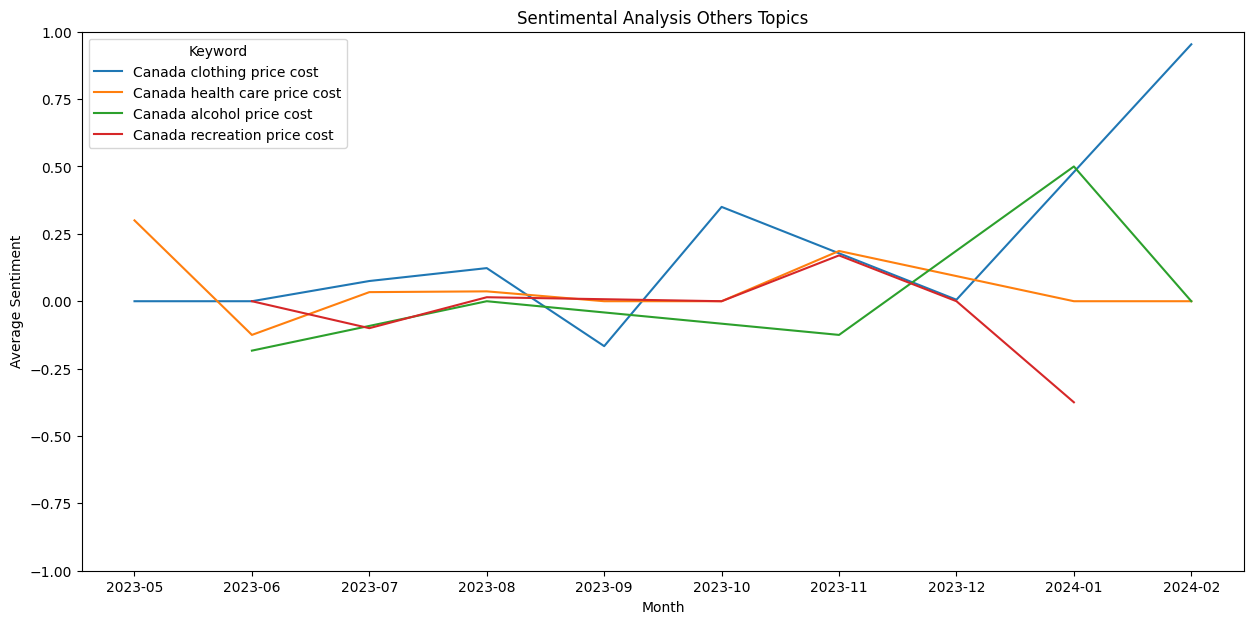

In [28]:
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define the keywords you want to consider
keywords_to_others = ['Canada clothing price cost', 'Canada health care price cost', 'Canada recreation price cost', 'Canada alcohol price cost']
# Filter sentiment_df to include only the rows where the 'Keyword' column is in keywords_to_consider
others_sentiment_df = sentiment_df[sentiment_df['Keyword'].isin(keywords_to_others)]

plt.figure(figsize=(15,7))
plt.title('Sentimental Analysis Others Topics')
sns.lineplot(data=others_sentiment_df,x = 'Month' , y = 'Average Sentiment', errorbar=('ci', False) ,hue='Keyword')
#for index, row in sentiment_df.iterrows():
#     plt.annotate(f'{row["Average Sentiment"]:.2f}', (row['Month'], row['Average Sentiment']), fontsize=10 )
plt.ylim(-1, 1)
plt.legend(title='Keyword')